In [1]:
%pylab inline
import cv2
import imutils
from imutils import contours
import matplotlib.patches as patches
import pytesseract

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the input image, resize it, and convert it to grayscale
image = cv2.imread("haar_classifier/new_supermarket_photos/spar_results/ok/77.jpg")
image = imutils.resize(image, width=300)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

/home/redhog/Projects/innovationgarage/price-tag-reader/env/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


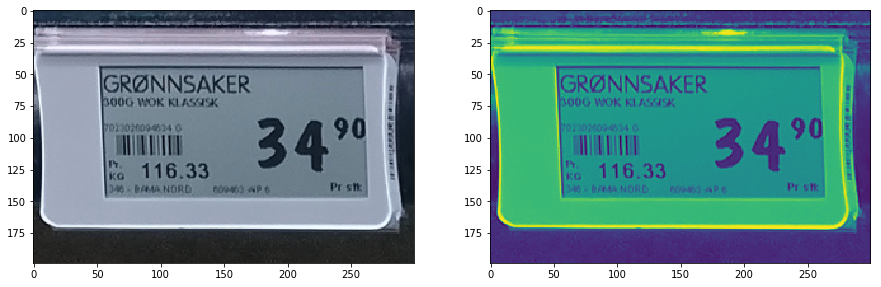

In [3]:
fig = plt.figure()
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs = axs.flatten()
axs[0].imshow(image)
axs[1].imshow(gray)
fig.show()

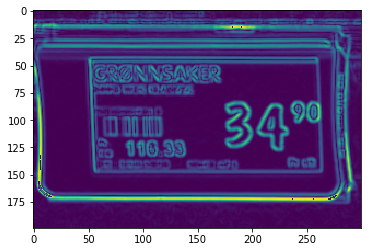

In [4]:
grads = []
for dx, dy in ((1, 0), (0, 1)):
    grad = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=dx, dy=dy,ksize=9)
    grad = np.absolute(grad)
    (minVal, maxVal) = (np.min(grad), np.max(grad))
    grad = (255 * ((grad - minVal) / (maxVal - minVal)))
    grad = grad.astype("uint8")
    #grad = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    grads.append(grad)

grad = grads[0] + grads[1]
plt.imshow(grad)
plt.show()

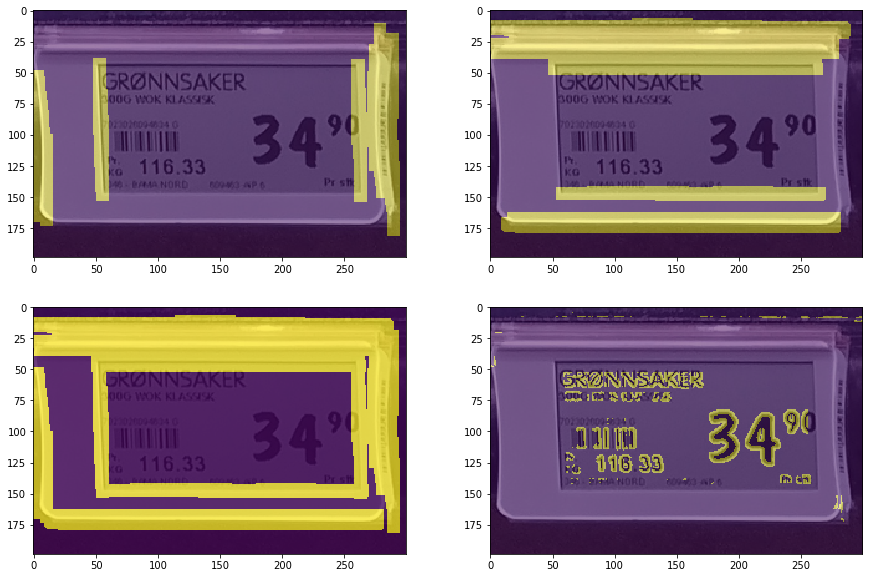

In [5]:
fig = plt.figure()
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs = axs.flatten()

rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
lines = [None, None]
for idx, (ax, kern) in enumerate(zip(axs, (cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40)),
                                           cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))))):
    lines[idx] = cv2.erode(grad, kern)
    lines[idx] = cv2.threshold(lines[idx], 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    lines[idx] = cv2.dilate(lines[idx], rectKern)
    lines[idx] = cv2.dilate(lines[idx], kern)

    ax.imshow(image, alpha=1)
    ax.imshow(lines[idx], alpha=0.5)

lines = lines[0] + lines[1]
objgrads = cv2.threshold(cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] - lines, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

axs[2].imshow(image, alpha=1)
axs[2].imshow(lines, alpha=0.5)
axs[2].imshow(lines, alpha=0.5)
axs[3].imshow(image, alpha=1)
axs[3].imshow(objgrads, alpha=0.5)

fig.show()

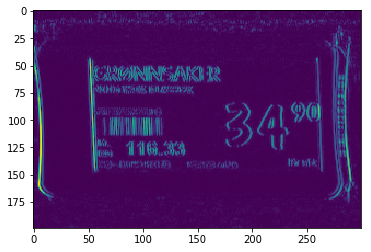

In [6]:
# compute the Scharr gradient of the tophat image, then scale
# the rest back into the range [0, 255]
gradX = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0,ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")
plt.imshow(gradX)
plt.show()

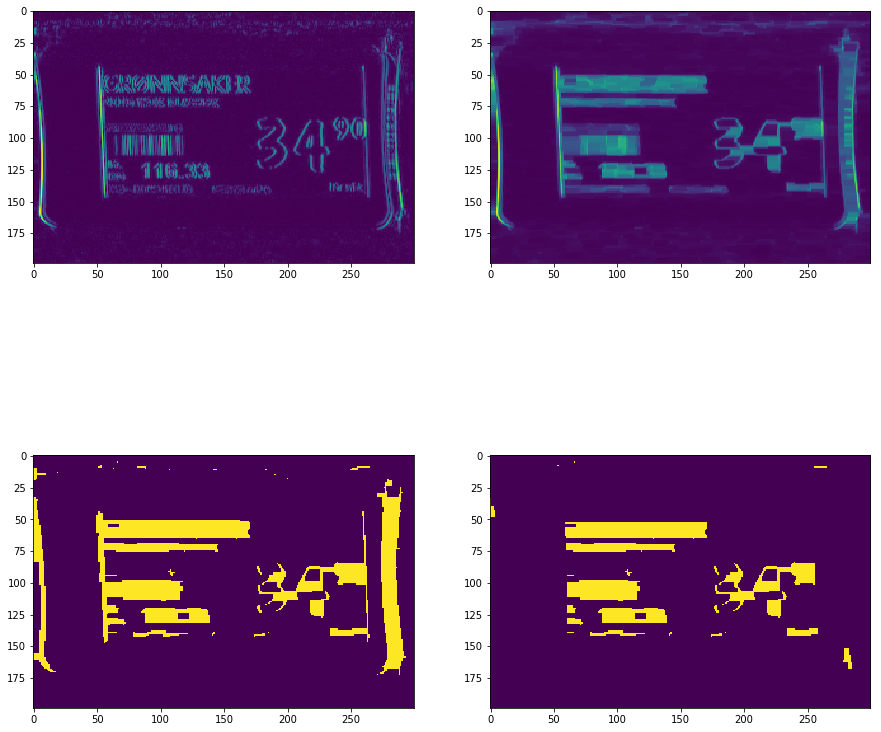

In [7]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))

gradXp = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
threshp = cv2.threshold(gradXp, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = threshp - lines
thresh = cv2.threshold(thresh, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

fig = plt.figure()
fig, axs = plt.subplots(2,2, figsize=(15,15))
axs = axs.flatten()
axs[0].imshow(gradX)
axs[1].imshow(gradXp)
axs[2].imshow(threshp)
axs[3].imshow(thresh)
fig.show()

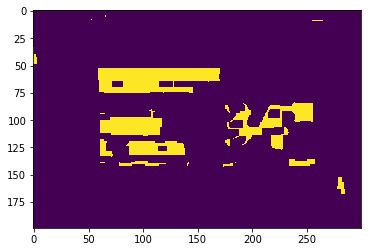

In [8]:
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
closedthresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
plt.imshow(closedthresh)
plt.show()

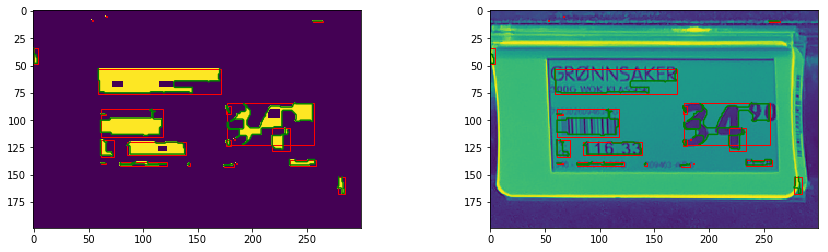

In [9]:
# find contours in the thresholded image, then initialize the
# list of digit locations
cnts = cv2.findContours(closedthresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
locs = []

fig, axs = plt.subplots(1,2, figsize=(15,4))
axs = axs.flatten()
axs[0].imshow(closedthresh)
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    axs[0].plot(c[:,0,0], c[:,0,1], color="green")
    axs[0].add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor="red"))
axs[1].imshow(gray)
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    axs[1].plot(c[:,0,0], c[:,0,1], color="green")
    axs[1].add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor="red"))
fig.show()

In [10]:
from PIL import Image
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    if w < 10 or h < 10: continue
    x -= 5
    y -= 5
    w += 10
    h += 10
    roi = gray[y:y + h, x:x + w]
    if not roi.shape[0] or not roi.shape[1]: continue
    print pytesseract.image_to_string(Image.fromarray(roi))


116.33


L IIM'I'uil
3490
GRINNSAKER

WM
